# Iris Flower-Speices Classifier

This project explores the classic Iris dataset using several machine learning classifiers for supervised learning. The dataset and the machine-learning results are appropriately visualized.

<br>**Goal :** Compare eight classic machine‑learning models on the classic Iris flower dataset 
<br>**Data :** 150 samples, 4 features, 3 species.
<br>**Result :** Best macro‑F1 = **0.98** (Support Vector Machines), all models >> 0.33 majority‑class baseline.

## Colab setup

In [1]:
# ⬇️ Colab setup: install lightweight requirements
try:
    import google.colab
    !pip install -q -r https://raw.githubusercontent.com/shaolinpat/flower_classifier/main/requirements-colab.txt
except ImportError:
    pass  # Not running in Colab

## Notebook setup

In [2]:
%matplotlib inline

# Imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap
import warnings
from pathlib import Path
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network  import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning
from tqdm import TqdmWarning

# Globals
sns.set_theme(style="white")
SEED = 22
np.random.seed(SEED)

# Create an artifacts directory
ART_DIR = Path("models")
ART_DIR.mkdir(exist_ok=True)

# Suppress benign warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=TqdmWarning)

## Data Prep

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names
target_labels = [n.capitalize() for n in target_names]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (120, 4), Test shape: (30, 4)


## Baseline (majority-class)

In [4]:
dummy = DummyClassifier(strategy="most_frequent", random_state=SEED).fit(
    X_train, y_train
)
baseline_acc = dummy.score(X_test, y_test)
print(f"Majority-class baseline accuracy: {baseline_acc:.2f}")

Majority-class baseline accuracy: 0.33


## Exploratory data analysis (EDA)

In [5]:
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df["species"] = pd.Categorical.from_codes(y, target_labels)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   species            150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


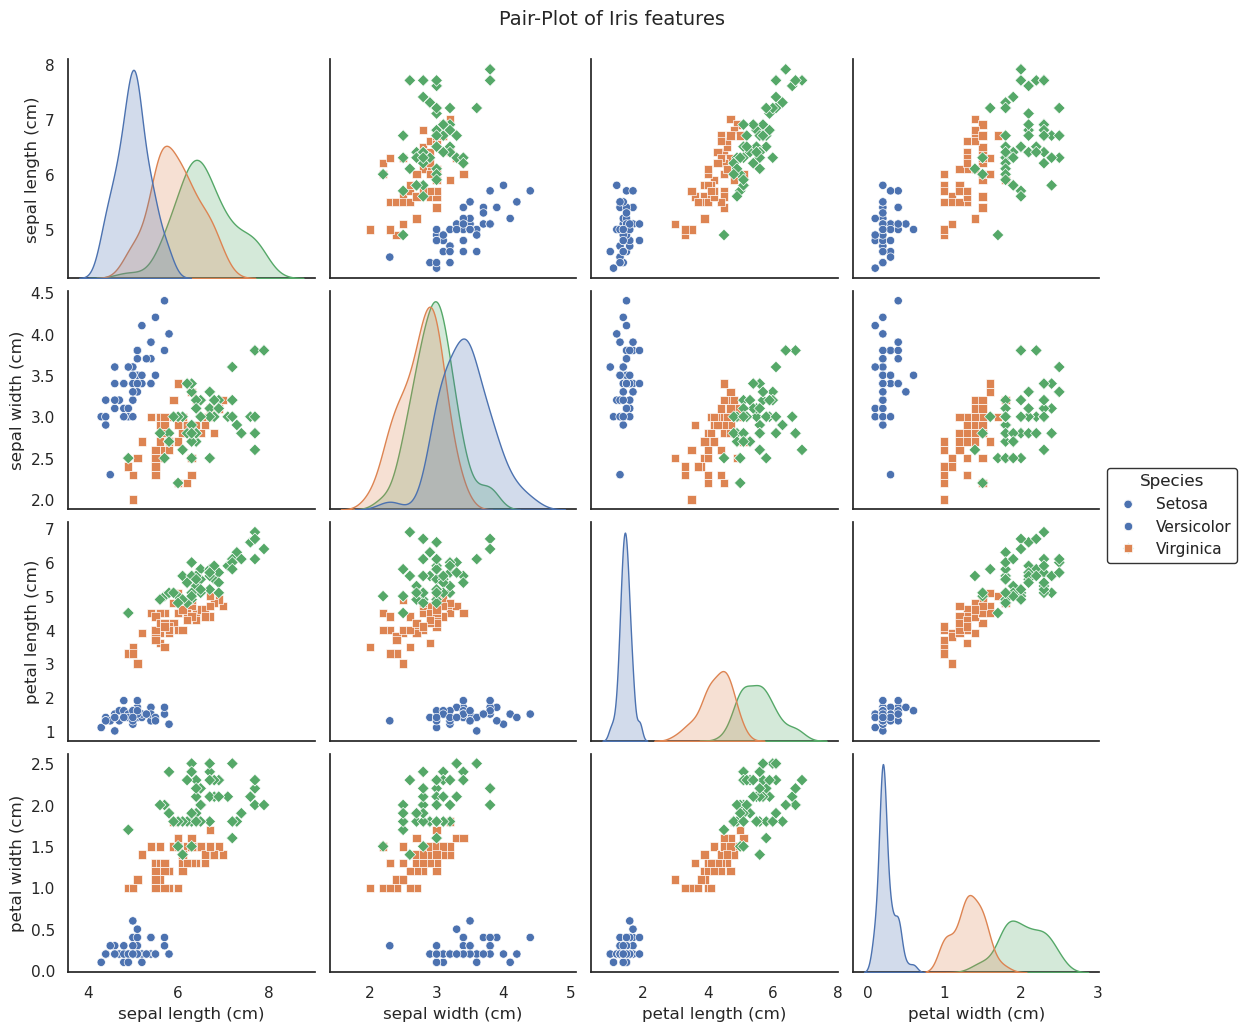

In [8]:
g = sns.pairplot(iris_df, hue="species", markers=["o", "s", "D"])
g.figure.suptitle("Pair-Plot of Iris features", x=0.5, y=1.03, fontsize=14)
g.add_legend(title="Species", frameon=True, labels=target_labels)
g._legend.get_frame().set_edgecolor("black")
g._legend.get_frame().set_linewidth(1)
plt.show()

*Fig 1 – Pair-plot of the Iris dataset*

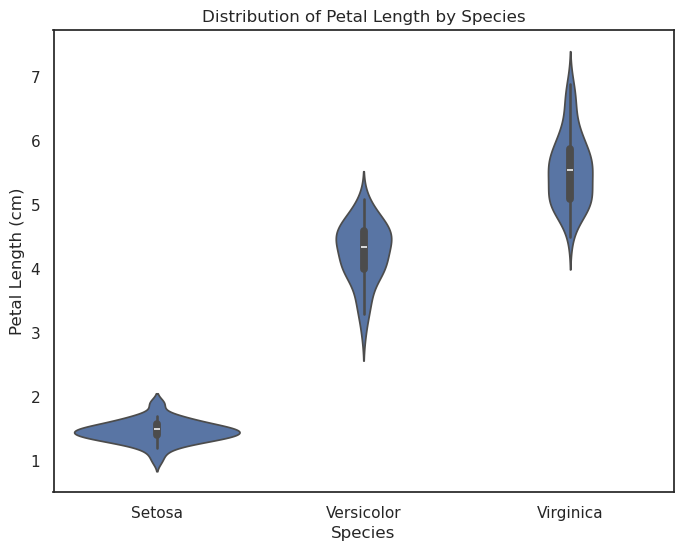

In [9]:
plt.figure(figsize=(8, 6))
sns.violinplot(x="species", y="petal length (cm)", data=iris_df)
plt.xlabel("Species")
plt.ylabel("Petal Length (cm)")
plt.title("Distribution of Petal Length by Species")
plt.show()

*Fig 2 – Violin plot shows petal length separates species well (sepal features overlap more)*

## Model grid & hyper‑parameter search

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

model_grid = {
    "Logistic Regression": (
        Pipeline(
            [
                ("scale", StandardScaler()),
                (
                    "clf",
                    LogisticRegression(
                        max_iter=1000, random_state=SEED, solver="lbfgs"
                    ),
                ),
            ]
        ),
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__max_iter": [1000, 5000],
        },
    ),
    "k-Nearest Neighbors": (
        Pipeline([("scale", StandardScaler()), ("clf", KNeighborsClassifier())]),
        {"clf__n_neighbors": [3, 5, 7], "clf__weights": ["uniform", "distance"]},
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=SEED),
        {"max_depth": [None, 3, 5, 10], "min_samples_split": [2, 4, 8]},
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=SEED),
        {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 5, 10],
            "class_weight": [None, "balanced"],
        },
    ),
    "Support Vector Machines": (
        Pipeline(
            [
                ("scale", StandardScaler()),
                ("clf", SVC(probability=True, random_state=SEED)),
            ]
        ),
        {
            "clf__C": [0.1, 1, 10],
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma": ["scale", "auto"],
        },
    ),
    "Naive Bayes": (GaussianNB(), {"var_smoothing": [1e-9, 1e-8, 1e-7]}),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=SEED),
        {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1], "max_depth": [2, 3]},
    ),
    "Multi Layer Perceptron": (
        Pipeline(
            [
                ("scale", StandardScaler()),
                (
                    "clf",
                    MLPClassifier(max_iter=600, random_state=SEED, early_stopping=True),
                ),
            ]
        ),
        {
            "clf__hidden_layer_sizes": [(64,), (64, 32)],
            "clf__alpha": [1e-4, 1e-3],
            "clf__learning_rate_init": [1e-3, 1e-2],
            "clf__max_iter": [600, 1500],
        },
    ),
}

results = []
for name, (estimator, grid) in model_grid.items():
    gs = GridSearchCV(estimator, grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    y_pred = gs.best_estimator_.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    results.append(
        {
            "model": name,
            "best_params": gs.best_params_,
            "cv_f1": gs.best_score_,
            "test_acc": test_acc,
            "best_estimator": gs.best_estimator_,
        }
    )

df_sorted = pd.DataFrame(results).sort_values("cv_f1", ascending=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


## Results and Evaluation

### Confusion matrix for the best model

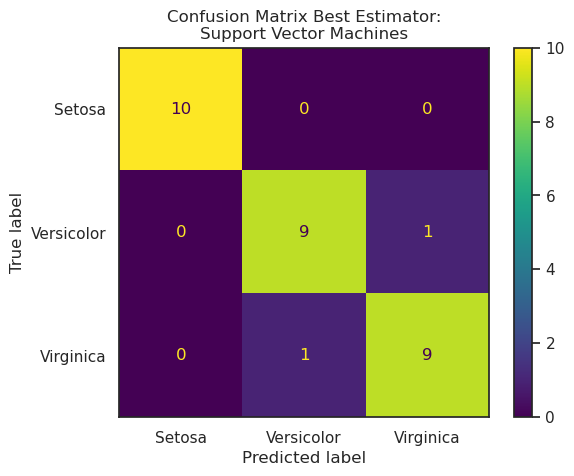

In [11]:
best_est = df_sorted.iloc[0]["best_estimator"]
ConfusionMatrixDisplay.from_estimator(
    best_est, X_test, y_test, display_labels=target_labels
)
plt.title(f"Confusion Matrix Best Estimator:\n{df_sorted.iloc[0]['model']}")
plt.show()

*Fig 3 – Confusion matrix for best performing classifier*

In [12]:
print(
    classification_report(
        y_test, best_est.predict(X_test), target_names=target_labels
    )
)

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.90      0.90      0.90        10
   Virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
for name, (estimator, _) in model_grid.items():
    scores = cross_val_score(estimator, X, y, cv=5, scoring="accuracy")
    print(f"{name} CV Average Accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

In [ ]:
test_acc = accuracy_score(y_test, gs.best_estimator_.predict(X_test))

ax = df_sorted.plot(
    x="model", y=["cv_f1", "test_acc"], kind="bar", figsize=(8, 6), rot=45
)
ax.set_ylabel("Score")
ax.set_xlabel("Model")
ax.set_title("Model Comparison (CV F1 vs. Test Accuracy)")
ax.legend(title="Score", frameon=True, edgecolor="black").get_frame().set_linewidth(1)
plt.tight_layout()

*Fig 4 – CV F1 vs. test accuracy for each model, sorted by decending score*

In [ ]:
# Results table with nicer number formatting
df_display = df_sorted.style.format({"cv_f1": "{:.3f}", "test_acc": "{:.3f}"})
df_display

## SHAP Explainer

In [ ]:
explainer = shap.Explainer(best_est.named_steps["clf"], X_train)
shap_values = explainer(X_test)

vals = np.abs(shap_values.values)
mean_abs = vals.mean(axis=0)

order = np.argsort(mean_abs.sum(axis=1))[::-1]
mean_abs = mean_abs[order]
feat_names = np.array(feature_names)[order]

palette = sns.color_palette("Set2", n_colors=len(target_labels))

fig, ax = plt.subplots(figsize=(8, 4))
left = np.zeros(len(feat_names))
for cls_idx, (cls, color) in enumerate(zip(target_labels, palette)):
    ax.barh(feat_names, mean_abs[:, cls_idx], left=left, color=color, label=cls)
    left += mean_abs[:, cls_idx]

ax.set_xlabel("Mean absolute SHAP value (average impact on predicted probability)")
ax.set_title("Mean absolute SHAP values per feature - Iris SVM model", pad=16)
ax.legend(title="Species", frameon=True, edgecolor="black").get_frame().set_linewidth(1)
plt.tight_layout()
plt.show()

*Fig 5 – Petal length/width dominate prediction; sepal features contribute modestly.*

In [ ]:
# Persist the best estimator for the Streamlit app
model_name = df_sorted.iloc[0]["model"].lower().replace(" ", "_")

Path("models").mkdir(exist_ok=True)
out_path = f"../models/{model_name}_flower_classifier.joblib"

if os.path.exists(out_path):                      # 1. Check if file exists
    os.remove(out_path)                           # 2. Remove it if it does

joblib.dump(best_est, out_path, compress=0)       # 3. Force overwrite
print(f"Saved best pipeline to {out_path}")

## Conclusion

This project demonstrates multiple classifiers applied to the Iris dataset. Some
hyperparameter tuning is preformed, and the results are deployed via Streamlit.

* **Baseline vs. models**  
  A majority-class dummy achieved accuracy ≈ 0.33. All eight classifiers
  easily surpassed this, with five scoring macro-F1 > 0.96.

* **Best model**  
  The tuned **Support Vector Machines** reached **macro-F1 0.975** and test
  accuracy 0.933, edging out Decision Trees and Logistic Regression (both at 
  0.966 and 0.933 for macro-F1 and test accuracy, respectively).

* **Key insights**  
  Pair-plot and feature-importance show petal length/width are the dominant
  separators, while sepal features overlap across species.

* **Deployment**  
  The winning pipeline (Support Vector Machines) is persisted with `joblib` and 
  loaded by a Streamlit app for interactive, real-time predictions.

## Next Steps

1. **Colab support**  
   - Add an “Open in Colab” badge linking to `flower_classifier.ipynb`  
   - Insert a top cell that installs dependencies (`!pip install -r requirements.txt`)

2. **Unit testing**  
   - Create `tests/` with pytest cases for data-prep and inference functions  
   - Ensure key functions (e.g. scaling + prediction) get validated automatically  

3. **Continuous Integration**  
   - Add a GitHub Actions workflow (`.github/workflows/ci.yml`) that on each push:  
       a. Installs dependencies  
       b. Runs pytest  
       c. Executes the notebook via nbconvert  
       d. Performs a smoke-test of the Streamlit app  